## Import libs and examples

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# cv2.__version__ == '4.1.0' https://docs.opencv.org/4.1.0/

# obs.: Notebook shortcuts: https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/

In [5]:
from glob import iglob
from os.path import basename, splitext, join

## Improve display quality on the notebook
**Note:** although we'll set a higher dpi for showing images, there are still (many) artifacts introduced when seeing them inside the notebook, thus, you should always check the images saved to the output folder (`o/`).

In [6]:
%matplotlib inline

In [7]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150 # 150 to 300 are good values

## Load examples

In [8]:
# load image examples into an array of tuples: (img: np.ndarray, img_name: str)
examples = []
for img_fname in iglob("i/*.png"):
    img_name = splitext(basename(img_fname))[0]
    img = cv2.imread(img_fname, cv2.IMREAD_GRAYSCALE)
    examples.append((img, img_name))

In [9]:
# shows a grayscale image without changing it's pixel values for display
# the image is saved as a .png if save_fname is not empty
def show_grayscale(img, img_title="", save_fname="", save_path="o"):
    plt.axis('off')
    plt.title(img_title)
    plt.imshow(img, cmap="gray", vmin=0, vmax=255)
    if save_fname:
        cv2.imwrite(join(save_path, save_fname + ".png"), img)

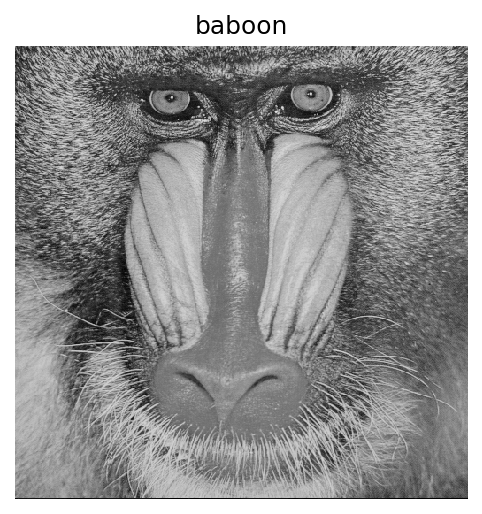

In [10]:
test_img = examples[0] # baboon
show_grayscale(*test_img)

## 1.1 Transformação de Intensidade

## $(i)$ Negativo da imagem

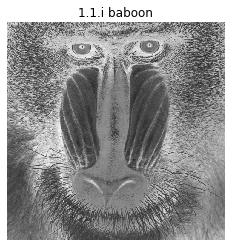

In [84]:
img = 255 - test_img[0] # [0, 255] -> [255, 0]
title = f"1.1.i {test_img[1]}"
show_grayscale(img, title, save_fname=title)

## $(ii)$ Converter o intervalo de intensidades para $[100, 200]$

min = 0, max = 230
min = 100.0, max = 190.19607843137254


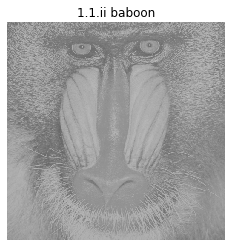

In [88]:
img = 100 * (test_img[0] / 255.0) + 100 # [0, 255] -> [100, 200]

title = f"1.1.ii {test_img[1]}"
show_grayscale(img, title, save_fname=title)

print(f"min = {np.min(test_img[0])}, max = {np.max(test_img[0])}")
print(f"min = {np.min(img)}, max = {np.max(img)}")

## 1.2 Ajuste de Brilho

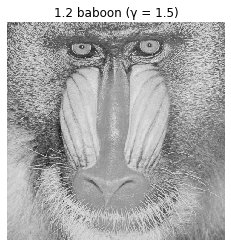

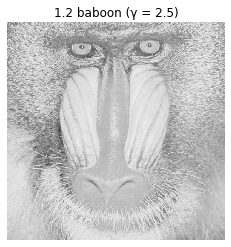

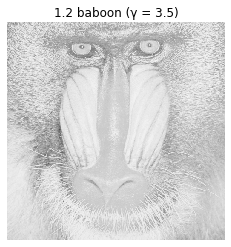

In [244]:
def gamma_correct(normalized_img, gamma):
    return normalized_img.copy() ** (1 / gamma)

normalized_img = (test_img[0] / 255.0) # [0, 255] -> [0, 1]
for gamma in [1.5, 2.5, 3.5]:
    title = f"1.2 {test_img[1]} (γ = {gamma})"
    fname = f"1.2 {test_img[1]} (gamma = {gamma})"
    show_grayscale(255.0 * gamma_correct(normalized_img, gamma), title, save_fname=fname)
    plt.show()

## 1.3 Planos de Bits

Os níveis de cinza de uma imagem monocromática com $m$ bits podem ser representados na forma de um polinomio de base 2: 
$a_{m−1} 2^{m−1} + a_{m−2} 2^{m−2} + . . . + a_{1} 2^{1} + a_{0} 2^{0}$


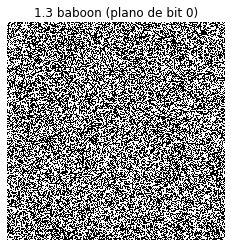

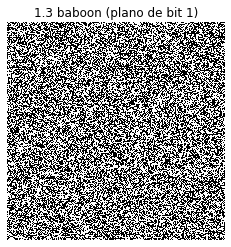

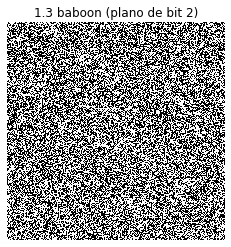

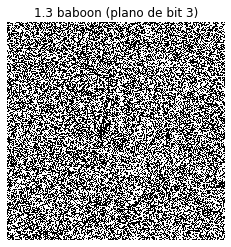

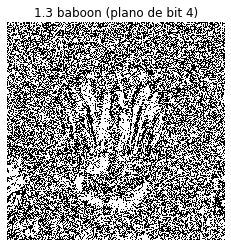

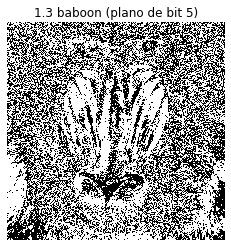

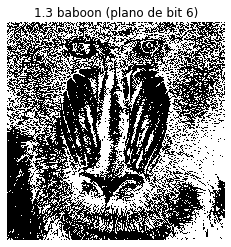

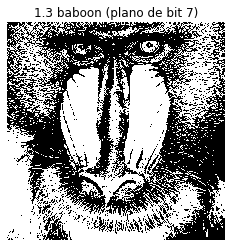

In [135]:
for plane in range(0, 8):
    img = (test_img[0] >> plane) & 1
    title = f"1.3 {test_img[1]} (plano de bit {plane})"
    show_grayscale(np.where(img, 255, 0), title, save_fname=title)
    plt.show()

## 1.4 Mosaico

Construir um mosaico de $4 \times 4$ blocos a partir de uma imagem monocromatica, com blocos numerados:

$
\begin{bmatrix} 
 1 &  2 &  3 &  4 \\
 5 &  6 &  7 &  8 \\
 9 & 10 & 11 & 12 \\
13 & 14 & 15 & 16
\end{bmatrix}
$

A nova ordem de disposição dos blocos deve seguir a numeração:

$
\begin{bmatrix} 
 6 & 11 & 13 &  3 \\
 8 & 16 &  1 &  9 \\
12 & 14 &  2 &  7 \\
 4 & 15 & 10 &  5
\end{bmatrix}
$

In [239]:
# obs.: img.shape == (height, width, depth)
# ref.: https://docs.scipy.org/doc/numpy/reference/generated/numpy.hstack.html
def mosaic(img, new_order, first_index_is_zero=False):
    rows, cols, *_ = new_order.shape
    dy = img.shape[0] // rows # height of each mosaic cell
    dx = img.shape[1] // cols # width of each mosaic cell
    
    if not first_index_is_zero:
        new_order -= 1
    
#     print(img.shape)
#     mosaic = img.reshape((rows, dy, cols, dx, -1));     print(mosaic.shape)
#     mosaic = mosaic.swapaxes(1, 2);                     print(mosaic.shape)
#     mosaic = mosaic.reshape((rows * cols, dy, dx, -1)); print(mosaic.shape)
#     mosaic = mosaic[new_order] # reorder the mosaic cells
#     mosaic = np.hstack(mosaic);                         print(mosaic.shape)
#     mosaic = np.hstack(mosaic);                         print(mosaic.shape)
#     mosaic = mosaic.reshape((*img.shape));              print(mosaic.shape)
#     return mosaic

    return (
        np.hstack(
            np.hstack(
                img
                    .reshape((rows, dy, cols, dx, -1))  # (512, 512)          -> (4, 128, 4, 128, 1)
                    .swapaxes(1, 2)                     # (4, 128, 4, 128, 1) -> (4, 4, 128, 128, 1)
                    .reshape((rows * cols, dy, dx, -1)) # (4, 4, 128, 128, 1) -> (16, 128, 128, 1)
                    [new_order]                         # reorders the mosaic cells
            )                                           # (16, 128, 128, 1)   -> (4, 512, 128, 1)
        )                                               # (4, 512, 128, 1)    -> (512, 512, 1)
        .reshape((*img.shape)))                         # (512, 512, 1)       -> (512, 512)

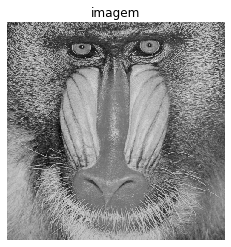

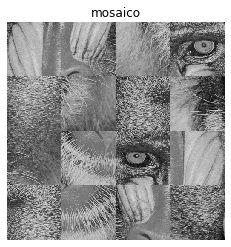

In [242]:
show_grayscale(test_img[0], "imagem")
plt.show()

img = mosaic(test_img[0], np.array([6,11,13,3,8,16,1,9,12,14,2,7,4,15,10,5]).reshape((4,4)))
show_grayscale(img, "mosaico", save_fname=f"1.4 {test_img[1]} (mosaico)")
plt.show()

## 1.5 Combinação de Imagens

In [120]:
def lerp(A, B, t):
    return t * A + (1 - t) * B

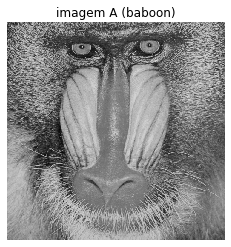

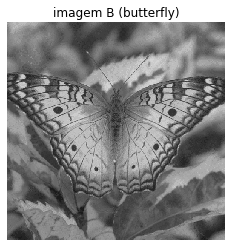

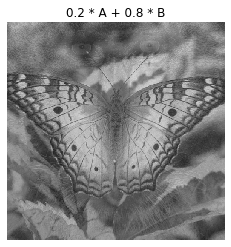

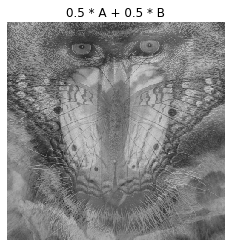

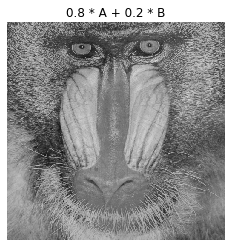

In [131]:
test_img_2 = examples[1] # butterfly

show_grayscale(test_img[0], f"imagem A ({test_img[1]})")
plt.show()
show_grayscale(test_img_2[0], f"imagem B ({test_img_2[1]})")
plt.show()

for t in [0.2, 0.5, 0.8]:
    show_grayscale(lerp(test_img[0], test_img_2[0], t), 
                   f"{t:.1f} * A + {1-t:.1f} * B", 
                   save_fname=f"1.5 lerp(A={test_img[1]}, B={test_img_2[1]}, t={t})")
    plt.show()